To implement RADAR for detecting AI-generated text:
1. Prompt large language models to rewrite text using rewriting prompts like "Help me polish this" or "Rewrite this for me" to gain contextual information for accurate detection 
2. Calculate the editing distance, such as the Levenshtein score, between the original and rewritten text to measure the modifications made by the model 
3. Utilize the differences in invariance to make predictions for detecting AI-generated content 

In [5]:
! pip -q install pandas
! pip -q install numpy
! pip -q install transformers --upgrade
! pip -q install torch torchvision torchaudio --upgrade
! pip -q install matplotlib
! pip -q install seaborn
! pip install tqdm
! pip -q install nltk
! pip install python-Levenshtein

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Vidushi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\Vidushi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\Vidushi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\Vidushi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Vidushi\AppData\Local\Programs\Python\Python312\Lib\http\client.py", line 479, in read
    s = se

In [3]:
import pandas as pd
import re
# Load the CSV file into a DataFrame
df = pd.read_csv("AI_Human.csv")
# Function to count words in a text
def count_words(text):
    # Split the text into words based on whitespace and count the number of resulting elements
    words = text.split()
    return len(words)

# Apply the word count function to the 'text' column and create a new column 'word_count'
df['word_count'] = df['text'].apply(count_words)

# Filter rows where 'generated' is 0.0 or 1.0 and word count is between 10 and 100
df = df[((df['generated'] == 0.0) | (df['generated'] == 1.0)) & 
                 (df['word_count'] >= 10) & 
                 (df['word_count'] < 100)]
# Filter rows where 'generated' is 0.0 or 1.0 and take the first 10 rows
zero_generated_rows = df[df['generated'] == 0.0].head(200000)
one_generated_rows = df[df['generated'] == 1.0].head(200000)

# Concatenate the two samples into a final DataFrame
final_sample = pd.concat([zero_generated_rows, one_generated_rows])

# Reset the index of the final sampled DataFrame
final_sample.reset_index(drop=True, inplace=True)

# Define a function to clean text while preserving spaces
def clean_text(text):
    # Remove newline characters and carriage returns
    cleaned_text = re.sub(r'[\n\r]', ' ', text)
    
    # Remove special characters except alphanumeric, spaces, and periods
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s\.]', '', cleaned_text)
    
    # Normalize multiple spaces into a single space
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    
    # Strip leading and trailing spaces
    cleaned_text = cleaned_text.strip()
    
    return cleaned_text

# Clean the 'text' column in the final sampled DataFrame
final_sample['text'] = final_sample['text'].apply(clean_text)

final_sample
# Replace values in the 'generated' column
final_sample['generated'] = final_sample['generated'].replace({0.0: 1.0, 1.0: 0.0})

# Display the updated DataFrame
final_sample


,text,generated,word_count
0,School should not follow this made because bus...,1.0,54
1,dear principal i think they should help to do ...,1.0,78
2,Dear TEACHERNAME I WRITE THIS LETTER TO SAID T...,1.0,48
3,Dear principal I think that is required to hav...,1.0,56
4,Dear friend my name is STUDENTNAME am coming f...,1.0,71
...,...,...,...
1354,In those years more and more people try their ...,0.0,54
1355,After researching the partnerships local compa...,0.0,89
1356,Nowadays when You search the internet You will...,0.0,75
1357,Hhere is a recent discussion about if young pe...,0.0,90


In [ ]:
# Generate BART Responses for 5 Prompts
import pandas as pd
import torch
from transformers import BartForConditionalGeneration, BartTokenizer
from tqdm import tqdm
df =final_sample
# Set up BART model and tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

# Define prompts with corresponding column names
prompts = [
    ("Rephrase my text", "BART_rephrase"),
    ("Help me refine this", "BART_refine"),
    ("Make this clearer", "BART_clear"),
    ("Please make this more concise", "BART_concise"),
    ("Humanize the text", "BART_Humanize")
]

# Function to generate BART response for a given human_text and prompt
def generate_bart_responses(texts, prompts):
    responses = []
    for text in tqdm(texts, desc="Generating BART responses"):
        text_responses = {}
        for prompt_text, column_name in prompts:
            input_text = f"{prompt_text}: {text}"
            input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
            with torch.no_grad():
                output_ids = model.generate(input_ids, max_length=100, min_length=10, num_beams=4, early_stopping=True)
            bart_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            text_responses[column_name] = bart_text
        responses.append(text_responses)
    return responses

# Process the dataset in batches
batch_size = 2
num_batches = (len(df) + batch_size - 1) // batch_size

all_responses = []
for batch_index in range(num_batches):
    start_index = batch_index * batch_size
    end_index = min((batch_index + 1) * batch_size, len(df))
    batch_texts = df['text'][start_index:end_index].tolist()
    batch_responses = generate_bart_responses(batch_texts, prompts)
    all_responses.extend(batch_responses)

# Convert responses to DataFrame
response_df = pd.DataFrame(all_responses)
final_df = pd.concat([df[:len(response_df)], response_df], axis=1)

# Display the final DataFrame with BART responses
print("\nFinal DataFrame with BART responses:")
final_df
output_file = "Dataset_1000.csv"
final_df.to_csv(output_file, index=False)
print(f"Subset of final DataFrame saved to '{output_file}'")

In [5]:
import pandas as pd

# Load DataFrame from CSV file
df = pd.read_csv("Dataset_1000.csv")

# Specify the number of rows to drop where 'generated' is 0
rows_to_drop = 1180

# Get indices of rows to drop based on the condition
indices_to_drop = df[df['generated'] == 0].index[:rows_to_drop]

# Drop the specified rows by their indices
df = df.drop(indices_to_drop)

# Display the resulting DataFrame after dropping rows
df

,text,generated,word_count,BART_rephrase,BART_refine,BART_clear,BART_concise,BART_Humanize
0,School should not follow this made because bus...,1,54,School should not follow this made because bus...,School should not follow this made because bus...,School should not follow this made because bus...,School should not follow this made because bus...,Humanize the text: School should not follow th...
1,dear principal i think they should help to do ...,1,78,Rephrase my text: dear principal i think they ...,Help me refine this: dear principal i think th...,Make this clearer: dear principal i think they...,Please make this more concise: dear principal ...,Humanize the text: dear principal i think they...
2,Dear TEACHERNAME I WRITE THIS LETTER TO SAID T...,1,48,Only the people that have good grades can play...,Only the people that have good grades can play...,Only the people that have good grades can play...,Only the people that have good grades can play...,Humanize the text: Dear TEACHERNAME I write th...
3,Dear principal I think that is required to hav...,1,56,Rephrase my text: Dear principal I think that ...,Help me refine this: Dear principal I think th...,Make this clearer: Dear principal I think that...,Please make this more concise: Dear principal ...,Humanize the text: Dear principal I think that...
4,Dear friend my name is STUDENTNAME am coming f...,1,71,Rephrase my text: Dear friend my name is STUDE...,Help me refine this: Dear friend my name is ST...,Make this clearer: Dear friend my name is STUD...,Please make this more concise: Dear friend my ...,Humanize the text: Dear friend my name is STUD...
...,...,...,...,...,...,...,...,...
1354,In those years more and more people try their ...,0,54,In those years more and more people try their ...,In those years more and more people try their ...,Make this clearer: In those years more and mor...,In those years more and more people try their ...,Many people are not able to go to university b...
1355,After researching the partnerships local compa...,0,89,After researching the partnerships local compa...,After researching the partnerships local compa...,After researching the partnerships local compa...,After researching the partnerships local compa...,After researching the partnerships local compa...
1356,Nowadays when You search the internet You will...,0,75,In this article I would like to share with You...,In this article I would like to share with You...,Make this clearer: Nowadays when You search th...,In this article I would like to share with You...,In this article I would like to share with You...
1357,Hhere is a recent discussion about if young pe...,0,90,I think the young people can enjoy life more b...,Help me refine this: What do you think is the ...,As far as I am concerned I think the young peo...,I think the young people can enjoy life more b...,I think the young people can enjoy life more b...


In [9]:
count_0 = (df['generated'] == 0).sum()
count_1 = (df['generated'] == 1).sum()
print(count_0)
print(count_1)

98
81


3. Measuring Change in Re-writing using BOW and Levenshtein distance

In [7]:
import pandas as pd
import Levenshtein as lev
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

bart_columns = ['BART_rephrase', 'BART_refine', 'BART_clear', 'BART_concise', 'BART_Humanize']

# Initialize CountVectorizer for BOW representation
vectorizer = CountVectorizer()

# Function to calculate Levenshtein distance and similarity ratio on BOW representations
def calculate_levenshtein_metrics(original_text, rewritten_text):
    original_array = vectorizer.fit_transform([original_text]).toarray()[0]
    rewritten_array = vectorizer.transform([rewritten_text]).toarray()[0]
    distance = lev.distance(original_array, rewritten_array)
    similarity_ratio = lev.ratio(original_text, rewritten_text)
    return distance, similarity_ratio

# Calculate Levenshtein distance and similarity ratio
for idx, row in df.iterrows():
    original_text = row['text']
    for response_col in bart_columns:
        rewritten_text = row[response_col]
        editing_distance, similarity_ratio = calculate_levenshtein_metrics(original_text, rewritten_text)
        df.at[idx, f'{response_col}_Editing_Distance'] = editing_distance
        df.at[idx, f'{response_col}_Similarity_Ratio'] = similarity_ratio

# Function to calculate invariance, uncertainty, and equivariance metrics
def calculate_metrics(df):
    invariance_values = []
    uncertainty_values = []
    equivariance_values = []

    for idx, row in df.iterrows():
        responses = [row[f'{col}_Editing_Distance'] for col in bart_columns]
        invariance_values.append(np.mean(responses))
        uncertainty_values.append(np.std(responses))

        original_text = row['text']
        equivariance = np.mean([calculate_levenshtein_metrics(original_text, row[col])[0] for col in bart_columns])
        equivariance_values.append(equivariance)

    return invariance_values, uncertainty_values, equivariance_values

invariance_values, uncertainty_values, equivariance_values = calculate_metrics(df)
df['Invariance'] = invariance_values
df['Uncertainty'] = uncertainty_values
df['Equivariance'] = equivariance_values

df


,text,generated,word_count,BART_rephrase,BART_refine,BART_clear,BART_concise,BART_Humanize,BART_rephrase_Editing_Distance,BART_rephrase_Similarity_Ratio,...,BART_refine_Similarity_Ratio,BART_clear_Editing_Distance,BART_clear_Similarity_Ratio,BART_concise_Editing_Distance,BART_concise_Similarity_Ratio,BART_Humanize_Editing_Distance,BART_Humanize_Similarity_Ratio,Invariance,Uncertainty,Equivariance
0,School should not follow this made because bus...,1,54,School should not follow this made because bus...,School should not follow this made because bus...,School should not follow this made because bus...,School should not follow this made because bus...,Humanize the text: School should not follow th...,0.0,1.000000,...,1.000000,1.0,0.989437,1.0,0.989437,1.0,0.967851,0.6,0.489898,0.6
1,dear principal i think they should help to do ...,1,78,Rephrase my text: dear principal i think they ...,Help me refine this: dear principal i think th...,Make this clearer: dear principal i think they...,Please make this more concise: dear principal ...,Humanize the text: dear principal i think they...,22.0,0.712991,...,0.892903,2.0,0.968675,11.0,0.881529,21.0,0.711916,13.6,7.337575,13.6
2,Dear TEACHERNAME I WRITE THIS LETTER TO SAID T...,1,48,Only the people that have good grades can play...,Only the people that have good grades can play...,Only the people that have good grades can play...,Only the people that have good grades can play...,Humanize the text: Dear TEACHERNAME I write th...,14.0,0.776042,...,0.760417,16.0,0.743316,13.0,0.788660,7.0,0.824295,12.8,3.059412,12.8
3,Dear principal I think that is required to hav...,1,56,Rephrase my text: Dear principal I think that ...,Help me refine this: Dear principal I think th...,Make this clearer: Dear principal I think that...,Please make this more concise: Dear principal ...,Humanize the text: Dear principal I think that...,16.0,0.742063,...,0.737673,16.0,0.740594,17.0,0.613445,17.0,0.740594,16.6,0.489898,16.6
4,Dear friend my name is STUDENTNAME am coming f...,1,71,Rephrase my text: Dear friend my name is STUDE...,Help me refine this: Dear friend my name is ST...,Make this clearer: Dear friend my name is STUD...,Please make this more concise: Dear friend my ...,Humanize the text: Dear friend my name is STUD...,16.0,0.756098,...,0.758308,20.0,0.678514,28.0,0.493739,20.0,0.652389,20.4,4.079216,20.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,In those years more and more people try their ...,0,54,In those years more and more people try their ...,In those years more and more people try their ...,Make this clearer: In those years more and mor...,In those years more and more people try their ...,Many people are not able to go to university b...,15.0,0.826840,...,0.965779,14.0,0.794179,5.0,0.949807,18.0,0.738739,11.2,5.635601,11.2
1355,After researching the partnerships local compa...,0,89,After researching the partnerships local compa...,After researching the partnerships local compa...,After researching the partnerships local compa...,After researching the partnerships local compa...,After researching the partnerships local compa...,26.0,0.749482,...,0.768131,26.0,0.749482,26.0,0.771109,26.0,0.771109,26.0,0.000000,26.0
1356,Nowadays when You search the internet You will...,0,75,In this article I would like to share with You...,In this article I would like to share with You...,Make this clearer: Nowadays when You search th...,In this article I would like to share with You...,In this article I would like to share with You...,27.0,0.692699,...,0.692699,29.0,0.694669,27.0,0.692699,27.0,0.674699,27.4,0.800000,27.4
1357,Hhere is a recent discussion about if young pe...,0,90,I think the young people can enjoy life more b...,Help me refine this: What do you think is the ...,As far as I am concerned I think the young peo...,I think the young people can enjoy life more b...,I think the young people can enjoy life more b...,31.0,0.748072,...,0.632168,28.0,0.787049,3

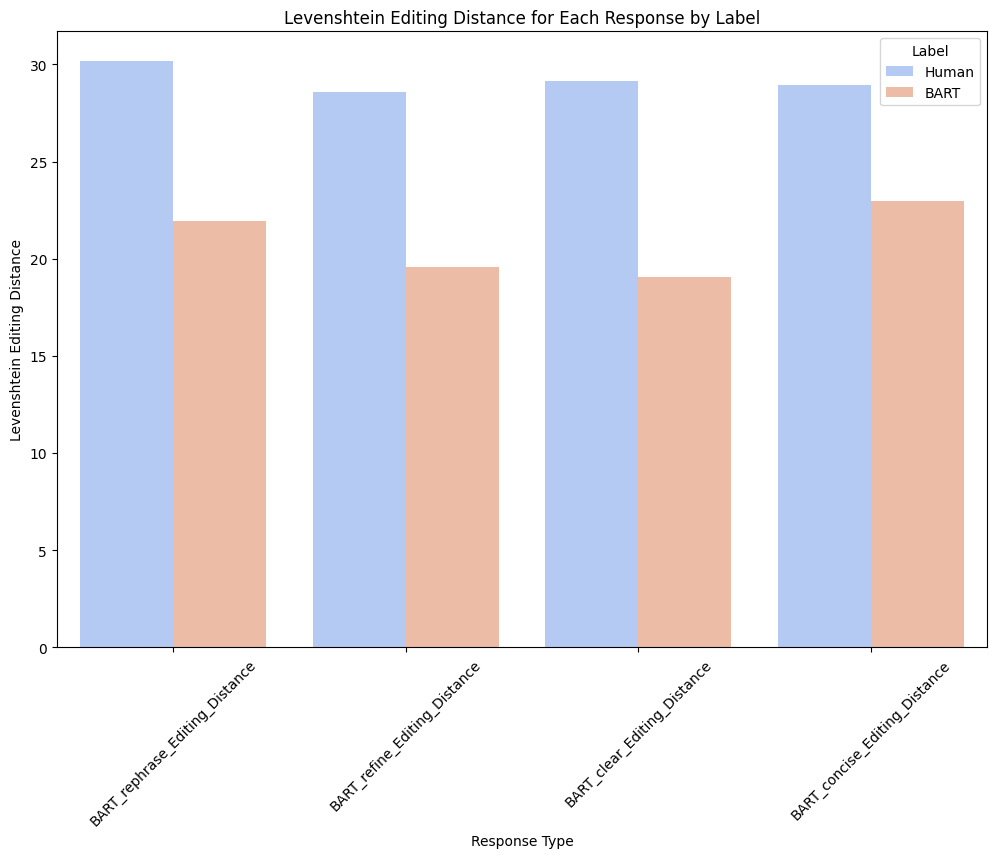

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
#Reshape the DataFrame for plotting
plot_df = pd.melt(df, id_vars=['generated'], value_vars=['BART_rephrase_Editing_Distance', 'BART_refine_Editing_Distance', 'BART_clear_Editing_Distance', 'BART_concise_Editing_Distance'],
                  var_name='Response', value_name='Editing_Distance')

plt.figure(figsize=(12, 8))
sns.barplot(x='Response', y='Editing_Distance', hue='generated', data=plot_df, palette='coolwarm', errorbar=None)  
plt.xlabel('Response Type')
plt.ylabel('Levenshtein Editing Distance')
plt.title('Levenshtein Editing Distance for Each Response by Label')
plt.xticks(rotation=45)
plt.legend(title='Label', labels=['Human', 'BART'])
plt.show()

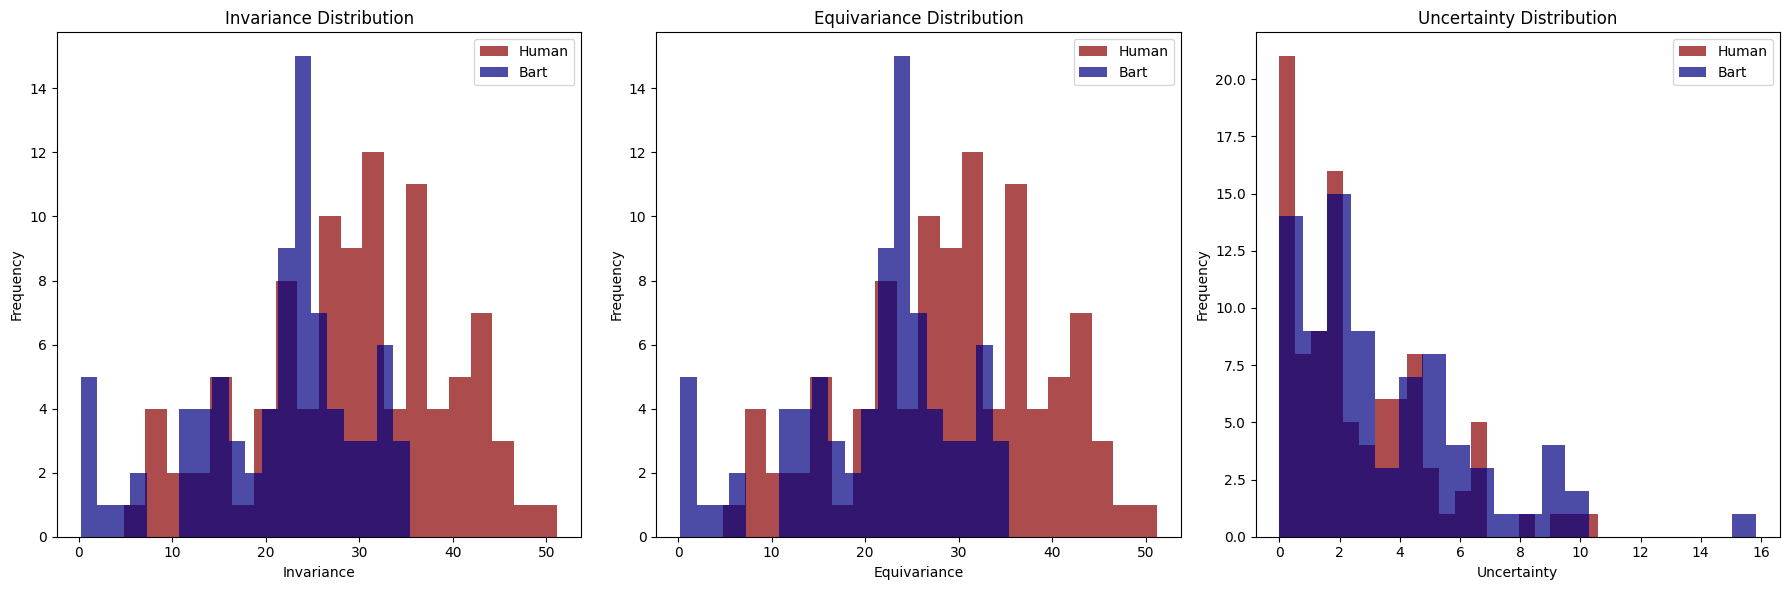

In [29]:
import matplotlib.pyplot as plt

# Separate data based on label
human_data = df[df['generated'] == 0.0]
bart_data = df[df['generated'] == 1.0]

# Plotting parameters
plt.figure(figsize=(18, 6))  # Set the figure size

# Plotting Invariance
plt.subplot(1, 3, 1)  # Create subplot for Invariance
plt.hist(human_data['Invariance'], bins=20, label='Human', color='darkred', alpha=0.7)
plt.hist(bart_data['Invariance'], bins=20, label='Bart', color='navy', alpha=0.7)
plt.xlabel('Invariance')
plt.ylabel('Frequency')
plt.title('Invariance Distribution')
plt.legend()

# Plotting Equivariance
plt.subplot(1, 3, 2)  # Create subplot for Equivariance
plt.hist(human_data['Equivariance'], bins=20, label='Human', color='darkred', alpha=0.7)
plt.hist(bart_data['Equivariance'], bins=20, label='Bart', color='navy', alpha=0.7)
plt.xlabel('Equivariance')
plt.ylabel('Frequency')
plt.title('Equivariance Distribution')
plt.legend()

# Plotting Uncertainty
plt.subplot(1, 3, 3)  # Create subplot for Uncertainty
plt.hist(human_data['Uncertainty'], bins=20, label='Human', color='darkred', alpha=0.7)
plt.hist(bart_data['Uncertainty'], bins=20, label='Bart', color='navy', alpha=0.7)
plt.xlabel('Uncertainty')
plt.ylabel('Frequency')
plt.title('Uncertainty Distribution')
plt.legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Define features (X) and target (y)
X = df[['BART_rephrase_Editing_Distance', 'BART_rephrase_Similarity_Ratio',
       'BART_refine_Editing_Distance', 'BART_refine_Similarity_Ratio',
       'BART_clear_Editing_Distance', 'BART_clear_Similarity_Ratio',
       'BART_concise_Editing_Distance', 'BART_concise_Similarity_Ratio',
       'BART_Humanize_Editing_Distance', 'BART_Humanize_Similarity_Ratio', 'Invariance', 'Uncertainty',
       'Equivariance']]
y = df['generated']

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=49)

# Initialize Logistic Regression classifier
logistic_regression = LogisticRegression(random_state=42)

# Train the classifier on the training data
logistic_regression.fit(X_train, y_train)

# Predictions on the test set
y_pred = logistic_regression.predict(X_test)

# Evaluate the model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy*100,'%')


Accuracy: 83.33333333333334 %


c:\Users\Vidushi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Checking Model on Test_Data
(Test data has been passed through the BART model to generate responses for the same 5 prompts)

In [11]:
import pandas as pd
import Levenshtein as lev
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Load your combined dataset
test_data = pd.read_csv("test_data.csv")
test_df = test_data

bart_columns = ['BART_rephrase', 'BART_refine', 'BART_clear', 'BART_concise', 'BART_Humanize']

# Initialize CountVectorizer for BOW representation
vectorizer = CountVectorizer()

# Function to calculate Levenshtein distance and similarity ratio on BOW representations
def calculate_levenshtein_metrics(original_text, rewritten_text):
    original_array = vectorizer.fit_transform([original_text]).toarray()[0]
    rewritten_array = vectorizer.transform([rewritten_text]).toarray()[0]
    distance = lev.distance(original_array, rewritten_array)
    similarity_ratio = lev.ratio(original_text, rewritten_text)
    return distance, similarity_ratio

# Calculate Levenshtein distance and similarity ratio
for idx, row in test_df.iterrows():
    original_text = row['text']
    for response_col in bart_columns:
        rewritten_text = row[response_col]
        editing_distance, similarity_ratio = calculate_levenshtein_metrics(original_text, rewritten_text)
        test_df.at[idx, f'{response_col}_Editing_Distance'] = editing_distance
        test_df.at[idx, f'{response_col}_Similarity_Ratio'] = similarity_ratio

# Function to calculate invariance, uncertainty, and equivariance metrics
def calculate_metrics(test_df):
    invariance_values = []
    uncertainty_values = []
    equivariance_values = []

    for idx, row in test_df.iterrows():
        responses = [row[f'{col}_Editing_Distance'] for col in bart_columns]
        invariance_values.append(np.mean(responses))
        uncertainty_values.append(np.std(responses))

        original_text = row['text']
        equivariance = np.mean([calculate_levenshtein_metrics(original_text, row[col])[0] for col in bart_columns])
        equivariance_values.append(equivariance)

    return invariance_values, uncertainty_values, equivariance_values

invariance_values, uncertainty_values, equivariance_values = calculate_metrics(test_df)
test_df['Invariance'] = invariance_values
test_df['Uncertainty'] = uncertainty_values
test_df['Equivariance'] = equivariance_values

test_df


,text,BART_rephrase,BART_refine,BART_clear,BART_concise,BART_Humanize,generated,BART_rephrase_Editing_Distance,BART_rephrase_Similarity_Ratio,BART_refine_Editing_Distance,BART_refine_Similarity_Ratio,BART_clear_Editing_Distance,BART_clear_Similarity_Ratio,BART_concise_Editing_Distance,BART_concise_Similarity_Ratio,BART_Humanize_Editing_Distance,BART_Humanize_Similarity_Ratio,Invariance,Uncertainty,Equivariance
0,Do curfews keep teenagers from Getting into tr...,The city council is debating whether or not to...,The city council is debating whether or not to...,The city council is debating whether or not to...,The city council is currently debating whether...,The city council is debating whether or not to...,0,251.0,0.128097,251.0,0.128097,255.0,0.129379,249.0,0.141067,256.0,0.139740,252.4,2.653300,252.4
1,The city council is currently debating on whet...,The city council is debating whether to adopt ...,The city council is currently debating on whet...,The city council is currently debating on whet...,The city council is currently debating on whet...,The city council is debating whether to adopt ...,1,2.0,0.978862,1.0,0.991974,1.0,0.991974,1.0,0.991974,3.0,0.970492,1.6,0.800000,1.6
2,"In this article ""The Challenge of Exploring Ve...",Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,0,223.0,0.212141,220.0,0.209804,220.0,0.209804,223.0,0.212141,220.0,0.209804,221.2,1.469694,221.2
3,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,Venus is the closest planet to Earth in terms ...,1,8.0,0.700000,8.0,0.700000,9.0,0.695364,9.0,0.695364,8.0,0.700000,8.4,0.489898,8.4
4,With THP rapid growth of THP Internet in recen...,Schools have always BPN in THP traditional env...,With THP rapid growth of THP Internet in recen...,Schools have always BPN in THP traditional env...,Online education would not only help THP overc...,With THP rapid growth of THP Internet in recen...,0,260.0,0.153220,260.0,0.173369,260.0,0.153220,259.0,0.151549,260.0,0.155305,259.8,0.400000,259.8
5,ThP question of whether or not school should e...,ThP question of whether or not school should e...,ThP question of whether or not school should e...,ThP question of whether or not school should e...,ThP question of whether or not school should e...,ThP question of whether or not school should e...,1,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.000000,0.0
6,The electoral College is the way Us United Sta...,The Electoral College is the way Us United Sta...,There is an argument whether or not to keep th...,The Electoral College is the way Us United Sta...,The Electoral College is the way Us United Sta...,Humanize the text: The electoral College is th...,0,212.0,0.211303,215.0,0.185818,212.0,0.207168,215.0,0.204261,217.0,0.172220,214.2,1.939072,214.2
7,The electoral College is the way Us United Sta...,Rephrase my text: The electoral College is the...,The electoral College is the way Us United Sta...,The electoral College is the way Us United Sta...,The electoral College is the way Us United Sta...,The electoral College is the way Us United Sta...,1,0.0,0.976064,0.0,1.000000,24.0,0.712813,0.0,0.659401,16.0,0.724551,8.0,10.119289,8.0
8,This technology of you can calculate the emoti...,This technology of you can calculate the emoti...,Emotional expressions can be used in classroom...,Emotional expressions can be used in classroom...,This technology of you can calculate the emoti...,Emotional expressions can be used in classroom...,0,124.0,0.289438,128.0,0.289544,122.0,0.281096,124.0,0.289438,120.0,0.278128,123.6,2.653300,123.6
9,This technology of you can calcula

In [13]:
from sklearn.metrics import f1_score
X_unlabeled = test_df[['BART_rephrase_Editing_Distance', 'BART_rephrase_Similarity_Ratio',
       'BART_refine_Editing_Distance', 'BART_refine_Similarity_Ratio',
       'BART_clear_Editing_Distance', 'BART_clear_Similarity_Ratio',
       'BART_concise_Editing_Distance', 'BART_concise_Similarity_Ratio',
       'BART_Humanize_Editing_Distance', 'BART_Humanize_Similarity_Ratio', 'Invariance', 'Uncertainty',
       'Equivariance']]

y_test_unseen = test_df['generated']

predictions = logistic_regression.predict(X_unlabeled)
accuracy_test = accuracy_score(y_test_unseen , predictions)

# Map predicted classes to human-readable labels
predicted_labels = ['Human Text' if pred == 0 else 'AI-generated Text' for pred in predictions]
test_df['predicted_label'] = predicted_labels
f1_score_test = f1_score(y_test_unseen, predictions)
print("Accuracy on Test Dataset:", accuracy_test*100,'%')
print("F1 Score on Test Dataset:", f1_score_test)
print("Predicted Labels for Unlabeled Data:")
test_df[['text', 'predicted_label','generated']] 


Accuracy on Test Dataset: 95.0 %
F1 Score on Test Dataset: 0.9473684210526315
Predicted Labels for Unlabeled Data:


,text,predicted_label,generated
0,Do curfews keep teenagers from Getting into tr...,Human Text,0
1,The city council is currently debating on whet...,AI-generated Text,1
2,"In this article ""The Challenge of Exploring Ve...",Human Text,0
3,Venus is the closest planet to Earth in terms ...,AI-generated Text,1
4,With THP rapid growth of THP Internet in recen...,Human Text,0
5,ThP question of whether or not school should e...,AI-generated Text,1
6,The electoral College is the way Us United Sta...,Human Text,0
7,The electoral College is the way Us United Sta...,Human Text,1
8,This technology of you can calculate the emoti...,Human Text,0
9,This technology of you can calculate the emoti...,AI-generated Text,1
